# Bonus

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

To start, we want to gather the sender and receiver of all emails.

Let's start by loading the email file. We only need the EmailId and the SenderPersonId

In [2]:
emails = pd.read_csv('hillary-clinton-emails/Emails.csv', usecols=['Id', 'SenderPersonId'])
emails.rename(columns={'Id':'EmailId'}, inplace=True)
emails.head()

,EmailId,SenderPersonId
0,1,87.0
1,2,NaN
2,3,32.0
3,4,32.0
4,5,80.0


Now let's load the receivers of the messages

In [3]:
receivers = pd.read_csv('hillary-clinton-emails/EmailReceivers.csv', index_col=0)
receivers.rename(columns={'PersonId':'ReceiverPersonId'}, inplace=True)
receivers.head()

,EmailId,ReceiverPersonId
Id,,
1,1,80
2,2,80
3,3,228
4,3,80
5,4,80


Now that we loaded both files, we can join them on the EmailId to get the sender and the receiver.

In [4]:
data = pd.merge(receivers, emails, on='EmailId').dropna()

print(len(data))
data.head(5)

9273


,EmailId,ReceiverPersonId,SenderPersonId
0,1,80,87.0
2,3,228,32.0
3,3,80,32.0
4,4,80,32.0
5,5,81,80.0


In [5]:
edges = data[['ReceiverPersonId', 'SenderPersonId']]
edges.head()

,ReceiverPersonId,SenderPersonId
0,80,87.0
2,228,32.0
3,80,32.0
4,80,32.0
5,81,80.0


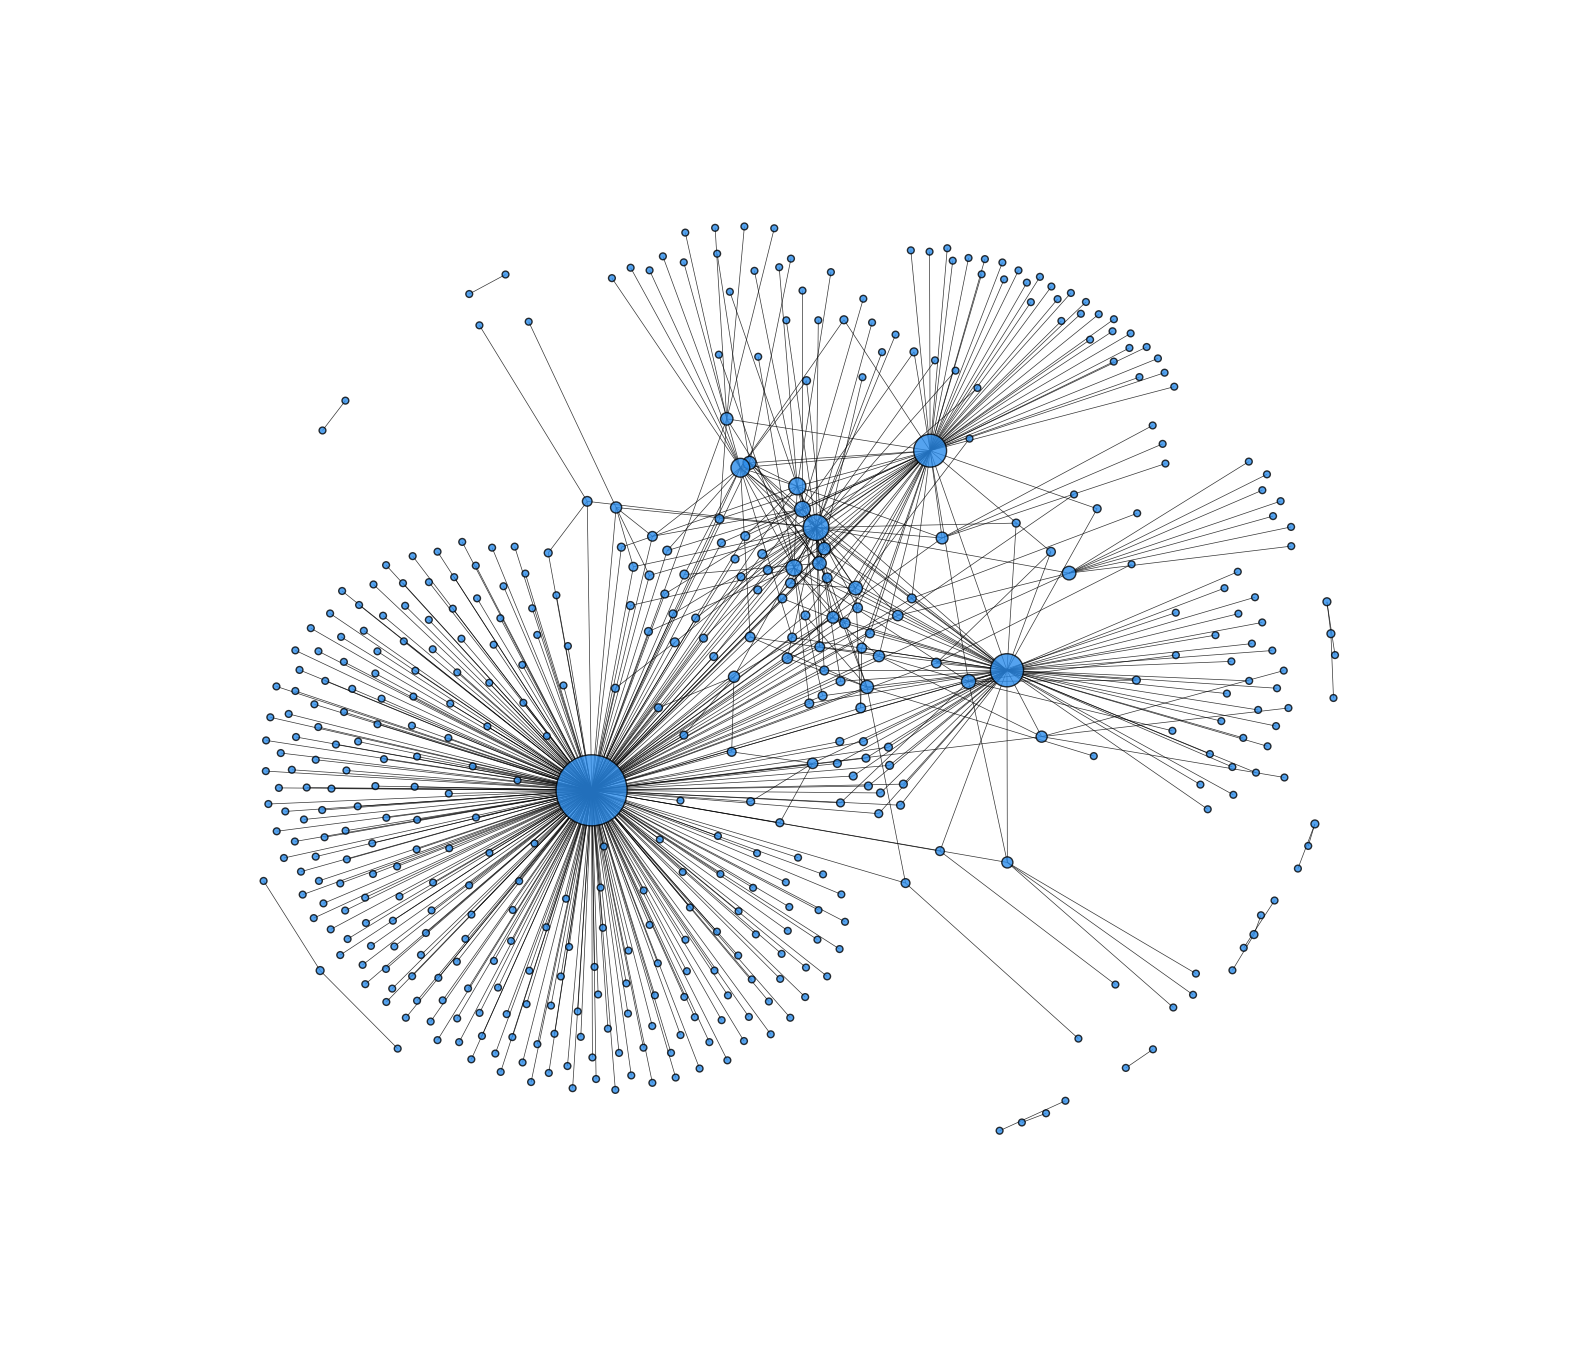

In [6]:
G = nx.from_pandas_dataframe(edges, 'ReceiverPersonId', 'SenderPersonId')
# We use the degree of the nodes to set their size
d = nx.degree(G)
node_size = [(v + 2) * 8 for v in d.values()]

fig = plt.figure(figsize=(15, 13))
nx.draw(G, nodelist=d.keys(), node_size=node_size, width=0.5, node_color='#2b8ceb', alpha=0.8)
plt.show()

## Communities
Now we want to see if there are communities in the graph.

In [7]:
import community
part = community.best_partition(G)
values = [part.get(node) for node in G.nodes()]

Let's plot the graph using the computed communities.

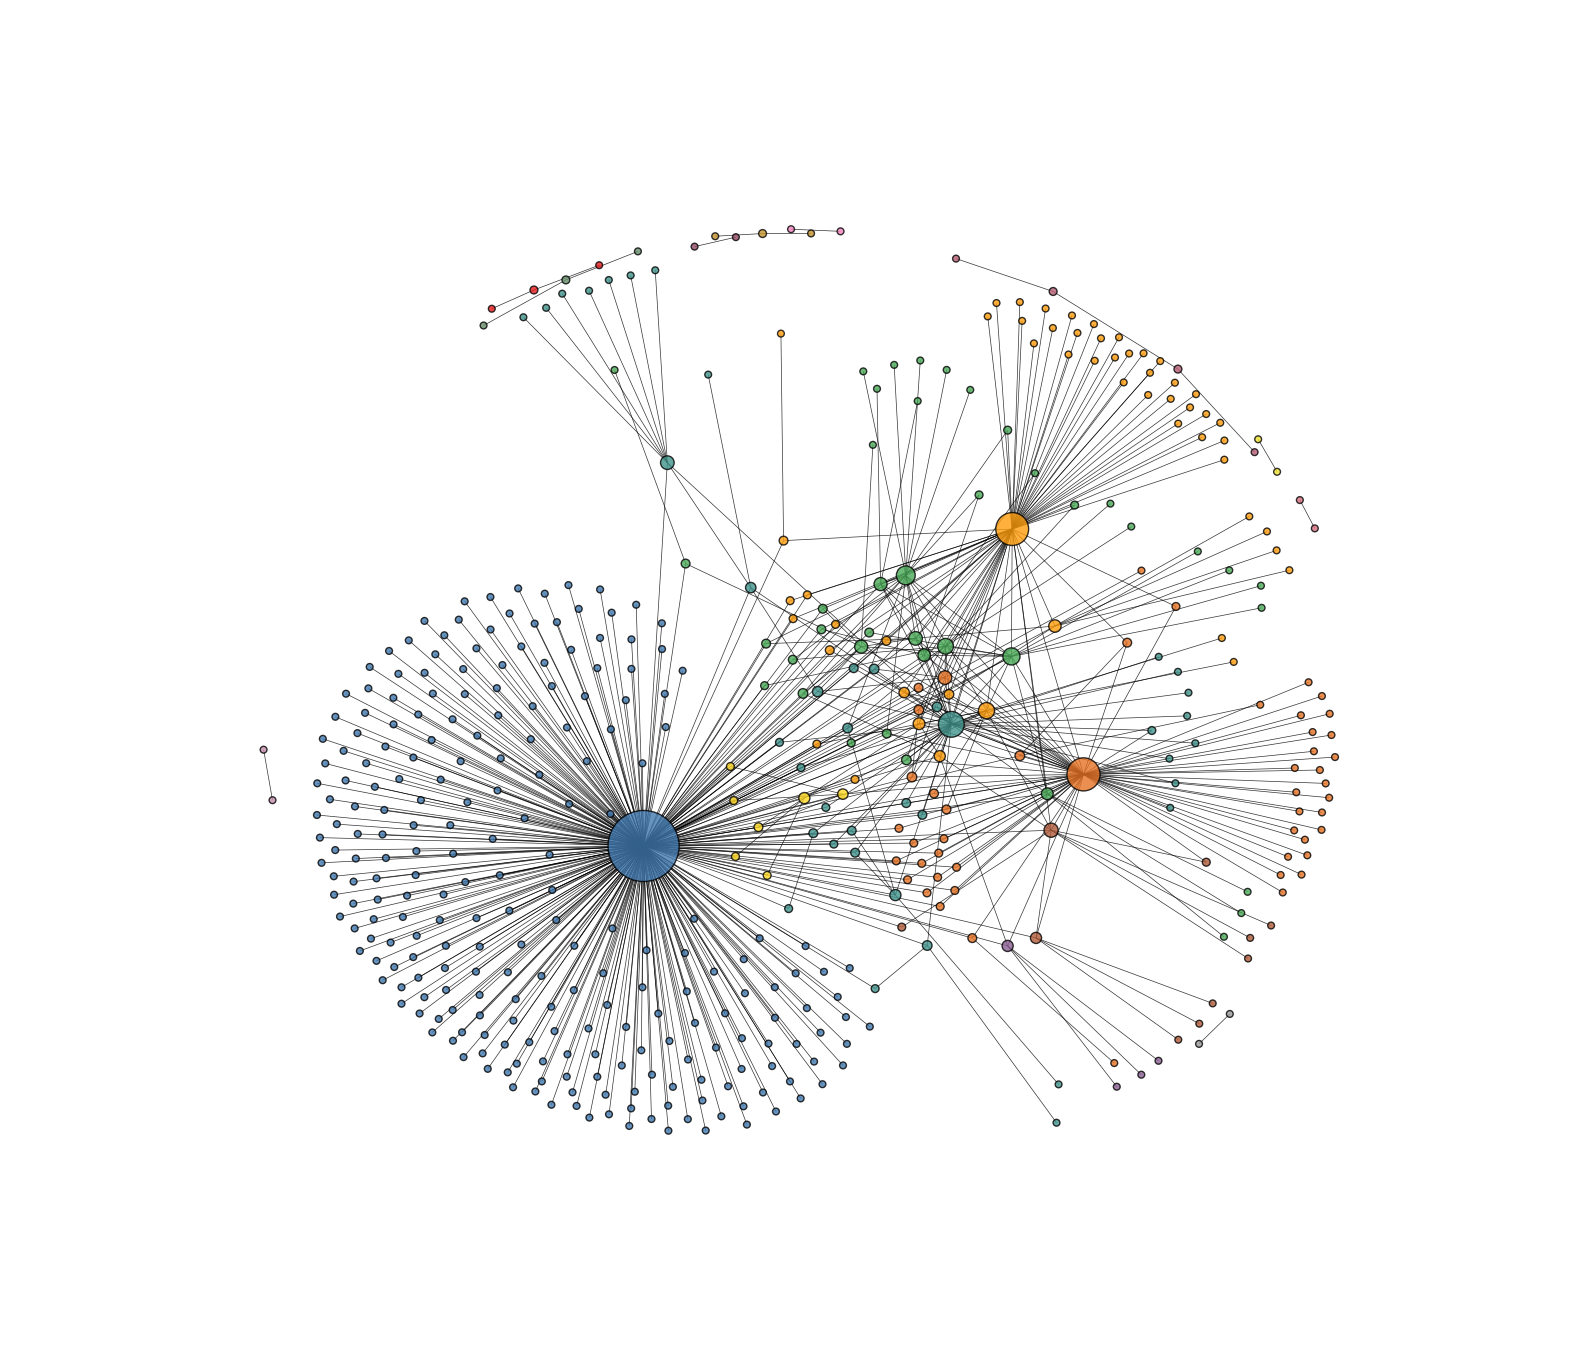

In [8]:
fig = plt.figure(figsize=(15, 13))


nx.draw_spring(G, cmap=plt.get_cmap('Set1'), node_color = values, node_size=node_size, alpha=0.8, width=0.5, with_labels=False)
plt.show()

## Top 20 words by communities

In [9]:
# We create a dataframe from the communities computed above.
groups = pd.DataFrame.from_dict(part, orient='index')
groups = groups.reset_index()
groups.rename(columns={0: 'group', 'index': 'PersonId'}, inplace=True)
groups.head()

,PersonId,group
0,4.0,0
1,5.0,1
2,7.0,2
3,9.0,3
4,10.0,4


In [10]:
emails = pd.read_csv('hillary-clinton-emails/Emails.csv', usecols=['Id', 'SenderPersonId', 'RawText']).dropna()
emails.rename(columns={'SenderPersonId': 'PersonId'}, inplace=True)
data = pd.merge(emails, groups, on='PersonId').dropna()

In [11]:
grouped_emails = data.groupby('group').apply(lambda x: "%s" % ' '.join(x['RawText']).replace('\n', ' ')).to_frame()
grouped_emails.rename(columns={0: 'emails'}, inplace=True)
grouped_emails.head()

,emails
group,
0,UNCLASSIFIED U.S. Department of State Case No....
1,UNCLASSIFIED U.S. Department of State Case No....
2,B6 UNCLASSIFIED U.S. Department of State Case ...
3,UNCLASSIFIED U.S. Department of State Case No....
4,UNCLASSIFIED U.S. Department of State Case No....


In [12]:
from nltk.corpus import stopwords

def word_count(txt, n):
    stop_words = stopwords.words("english")
    word_list = txt.split()
    count = {}
    for word in word_list:
        if word not in stop_words:
            if word in count:
                count[word] = count[word] + 1
            else:
                count[word] = 0
    return sorted(count, key=count.get, reverse=True)[:n]

        
grouped_emails['top_words'] = grouped_emails['emails'].apply(lambda emails: word_count(emails, 20))
grouped_emails

,emails,top_words
group,,
0,UNCLASSIFIED U.S. Department of State Case No....,"[U.S., No., UNCLASSIFIED, State, Department, D..."
1,UNCLASSIFIED U.S. Department of State Case No....,"[No., 06/30/2015, Case, C05758521, U.S., UNCLA..."
2,B6 UNCLASSIFIED U.S. Department of State Case ...,"[No., U.S., State, Department, Date:, UNCLASSI..."
3,UNCLASSIFIED U.S. Department of State Case No....,"[No., U.S., State, Department, Date:, UNCLASSI..."
4,UNCLASSIFIED U.S. Department of State Case No....,"[No., U.S., State, Department, Date:, UNCLASSI..."
5,UNCLASSIFIED U.S. Department of State Case No....,"[U.S., No., State, Cuba, Department, Doc, 08/3..."
6,UNCLASSIFIED U.S. Department of State Case No....,"[No., State, U.S., Department, Date:, Case, F-..."
7,RELEASE IN FULL PRESIDENT OF 'MONGOLIA MOHrOJI...,"[-, I, No., UN, people, Haitian, settlements, ..."
8,UNCLASSIFIED U.S. Department of State Case No....,"[No., U.S., State, Department, UNCLASSIFIED, D..."
